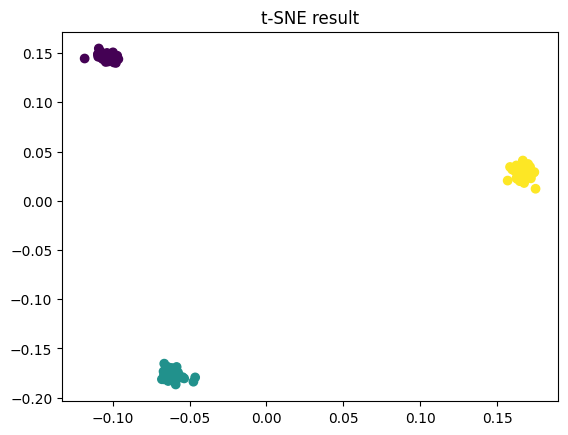

In [6]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
from jax import grad, jit, vmap


def getProbs(X, goal_perplexity):
    n = X.shape[0]
    probs = np.zeros((n, n))
    tol = 1e-5  # window for perplexity convergence

    for i in range(n):  # computing the probabilities repeatedly to search for correct sigmas for each row
        sigMin, sigMax = 1e-10, 1e3
        searchIters = 50

        for _ in range(searchIters):  # binary search
            sig = (sigMax + sigMin) / 2
            for j in range(n):
                if i != j:
                    probs[i, j] = np.exp(-np.linalg.norm(X[i] - X[j]) ** 2 / (2 * sig ** 2))
                else:
                    probs[i, j] = 0

            sum_probs_i = np.sum(probs[i])
            if sum_probs_i > 0:
                probs[i] /= sum_probs_i  # normalize probabilities

            entropy = -np.sum(probs[i] * np.log2(probs[i] + 1e-10))  # calc entropy for the row
            current_perplexity = 2 ** entropy  # calc current perplexity using entropy

            if current_perplexity > goal_perplexity:
                sigMax = sig
            else:
                sigMin = sig

            if abs(current_perplexity - goal_perplexity) < tol:
                break

    P = (probs + probs.T) / (2 * n) # symmetrize probability matrix

    return P


def compute_Q(Y):
    """Compute the Q matrix for low-dimensional embeddings Y using t-SNE's Cauchy distribution."""
    n = Y.shape[0]
    sum_Y = jnp.sum(jnp.square(Y), axis=1)
    D = jnp.add(jnp.add(-2 * jnp.dot(Y, Y.T), sum_Y).T, sum_Y)
    Q = jnp.power(1 + D, -1)
    Q = Q * (1 - jnp.eye(n))  # Set diagonal to zero
    Q /= jnp.sum(Q)
    Q = jnp.maximum(Q, 1e-10)  # Ensure numerical stability
    return Q

def KL_divergence(P, Y):
    """Compute the KL divergence between the high-dimensional P matrix and low-dimensional Q matrix."""
    Q = compute_Q(Y)
    return jnp.sum(P * jnp.log2(P / Q + 1e-10))

kl_div_grad = jit(grad(KL_divergence, argnums=1))

"""
ok what do i need to do next: i need to get


"""


from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, labels = make_blobs(n_samples=300, centers=3, n_features=50, random_state=42)

goal_perplexity = 30
P = getProbs(X, goal_perplexity)

key = random.PRNGKey(42)
Y = random.normal(key, (X.shape[0], 2)) * 1e-4

learning_rate = 1e-2
num_iterations = 50000

for _ in range(num_iterations):
    gradients = kl_div_grad(P, Y)
    Y -= learning_rate * gradients

# Plot the result
plt.scatter(Y[:, 0], Y[:, 1], c=labels)
plt.title("t-SNE result")
plt.show()
